In [22]:
import pandas as pd, numpy as np
import lightgbm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [23]:
df = pd.read_csv('Telco_customer_churn.csv', sep=',')
df.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


In [24]:
# Let's delete data leakage columns and columns with 1 unique catigory
drop_cols = ['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason', 'Count', 'Country', 'State', 'Lat Long', 'CustomerID']
df.drop(drop_cols, axis=1, inplace=True)

In [25]:
# We already know that NaNs are not mapped. But we have white spaces in data, so we will replace them with NaNs
# df.loc[df['Total Charges'] == ' ']
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# df.isna().sum()

In [26]:
# Replace ',' with '.' to convert to float
to_be_numeric = ['Latitude', 'Longitude', 'Monthly Charges', 'Total Charges']

for col in to_be_numeric:
    df[col].replace(',', '.', regex=True, inplace=True)
    df[col] = pd.to_numeric(df[col])

In [27]:
# Let's find catigorical columns
cat_columns = [cname for cname in df.columns if df[cname].dtype == "object"]

# We need 'categorical' type for categorical columns for lightgbm
for col in df.columns:
    if col in cat_columns:
        df[col] = df[col].astype('category')

In [28]:
# Splitting the data 
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

roc_auc of base model: 0.7085373009663571

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1048
           1       0.60      0.54      0.57       361

    accuracy                           0.79      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


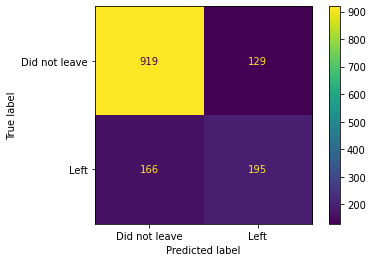

In [29]:
# Base model
lgb_base = lightgbm.LGBMClassifier(random_state=0)
lgb_base.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='auc', verbose=0)

print(f'roc_auc of base model: {roc_auc_score(y_valid, lgb_base.predict(X_valid))}\n')
print(classification_report(y_valid, lgb_base.predict(X_valid)))
plot_confusion_matrix(lgb_base, X_valid, y_valid, values_format='d', display_labels=['Did not leave', 'Left'])

With base model we can see that 166 cases (46%) of churn were not identified. In this kind of task you would want lower false negatives than false positives, so we will tune that

In [30]:
%%time
param_grid = {
              'max_depth': [4, 9, -1],
              'num_leaves': [4, 9],
              'learning_rate': [0.1],
              'scale_pos_weight': [3],
              'n_estimators': [50, 100],
              'reg_lambda': [10, 15],
              'subsample': [0.9],
              'colsample_bytree': [0.5, 0.6]
              }

lgb = lightgbm.LGBMClassifier(random_state=1)

opt_params = GridSearchCV(estimator=lgb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=3)

opt_params.fit(X_train, y_train, eval_metric='auc', eval_set=(X_valid, y_valid), verbose=0)
params = opt_params.best_params_
print(params)

{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'num_leaves': 9, 'reg_lambda': 10, 'scale_pos_weight': 3, 'subsample': 0.9}
CPU times: user 45.7 s, sys: 490 ms, total: 46.2 s
Wall time: 27.7 s


roc_auc of final model: 0.7719518513036306

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1048
           1       0.50      0.83      0.62       361

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.82      0.74      0.76      1409



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


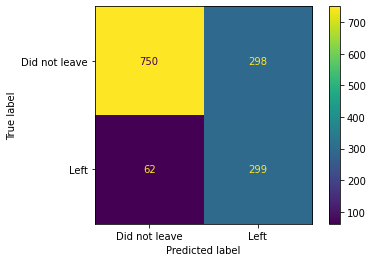

In [31]:
lgb = lightgbm.LGBMClassifier(**params)
lgb.fit(X_train, y_train)

print(f'roc_auc of final model: {roc_auc_score(y_valid, lgb.predict(X_valid))}\n')
print(classification_report(y_valid, lgb.predict(X_valid)))
plot_confusion_matrix(lgb, X_valid, y_valid, values_format='d', display_labels=['Did not leave', 'Left'])